In [11]:
import os
#os.chdir("../")
os.getcwd()

'/home/onyxia/work/detection-habitat-spontane/src'

In [12]:
import yaml 
from yaml.loader import SafeLoader
%load_ext autoreload
%autoreload 2
from run_training_pipeline import (
download_data,
prepare_data,
instantiate_dataset,
instantiate_model,
instantiate_loss,
instantiate_trainer,
instantiate_dataloader,
download_prepare_test
)
from train_pipeline_utils.download_data import load_donnees_test
from classes.data.satellite_image import SatelliteImage
from classes.data.labeled_satellite_image import SegmentationLabeledSatelliteImage
from utils.plot_utils import plot_list_segmentation_labeled_satellite_image
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
# length_delete = 75
# dir_path = "../data/PLEIADES/2022/MARTINIQUE/"

# files = os.listdir(dir_path)[:length_delete]

# for file in files:
#     file_path = os.path.join(dir_path, file)
#     if os.path.isfile(file_path):
#         os.remove(file_path)


In [13]:
with open("../config.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

list_data_dir = download_data(config)

In [14]:
list_output_dir = prepare_data(config, list_data_dir)
#download_prepare_test(config)
model = instantiate_model(config)


fichiers déjà écrits


In [15]:
train_dl, valid_dl, test_dl = instantiate_dataloader(
    config, list_output_dir
)

In [6]:
import numpy as np

id_batch 0
id_batch 1
id_batch 2
id_batch 3
id_batch 4
id_batch 5
id_batch 6
id_batch 7
id_batch 8
id_batch 9
id_batch 10
id_batch 11
id_batch 12
id_batch 13
id_batch 14
id_batch 15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


id_batch 16
id_batch 17
id_batch 18
id_batch 19
id_batch 20
id_batch 21
id_batch 22
id_batch 23
id_batch 24
id_batch 25
id_batch 26
id_batch 27
id_batch 28
id_batch 29
id_batch 30
id_batch 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


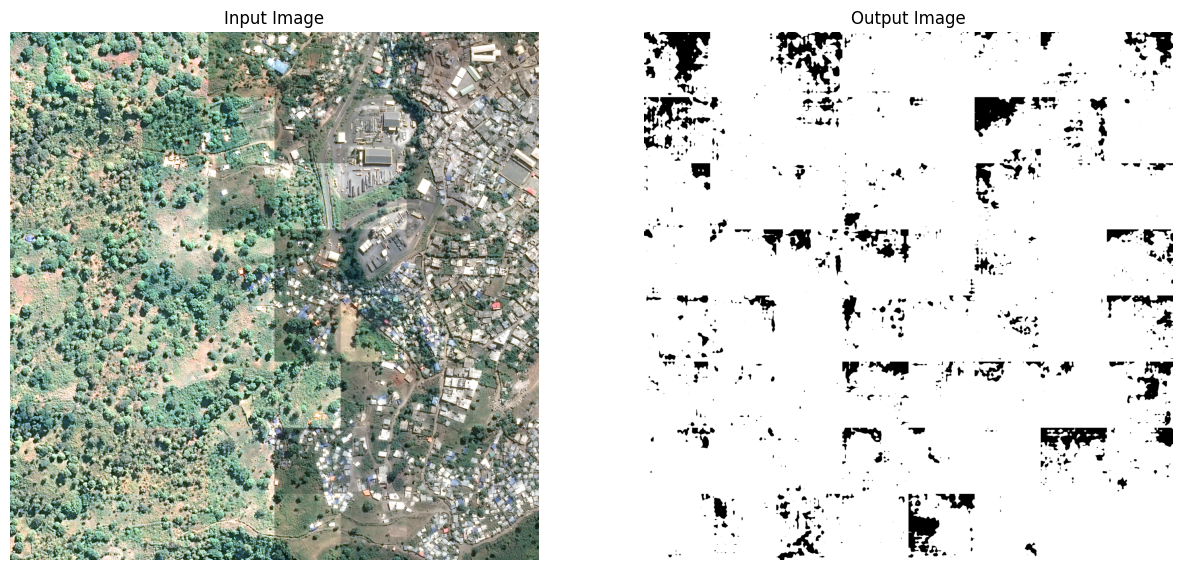

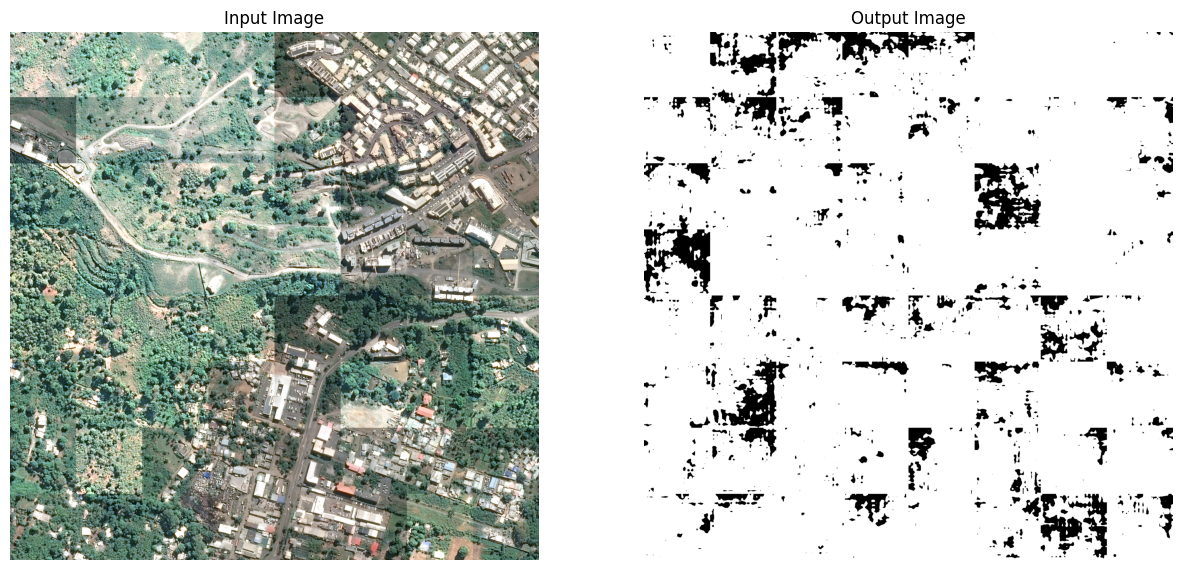

In [38]:
tile_size = config["donnees"]["tile size"]
batch_size = config["optim"]["batch size test"]
list_labeled_satellite_image = []

npatch = int((2000/tile_size)**2)
nbatchforfullimage = int(npatch/batch_size)

if not npatch % nbatchforfullimage == 0:
    print("Le nombre de patchs n'est pas divisible par la taille d'un batch")
    #return None 

for idx, batch in enumerate(test_dl):
    print("id_batch",idx)
    images, label, dic = batch
    output_model = model(images)
    mask_pred = np.array(torch.argmax(output_model, axis  = 1))

    for i in range(batch_size):    
        pthimg = dic["pathimage"][i]
        si = SatelliteImage.from_raster(
                file_path = pthimg,
                dep = None,
                date = None,
                n_bands= 3)
        si.normalize()
        
        list_labeled_satellite_image.append( 
            SegmentationLabeledSatelliteImage(
                satellite_image =  si ,
                label= mask_pred[i],
                source= "",
                labeling_date = ""
            )
        )
        

        
    if ((idx+1) % nbatchforfullimage) == 0:
        
        if not os.path.exists("img/"):
            os.makedirs("img/")
        
        fig1 = plot_list_segmentation_labeled_satellite_image(list_labeled_satellite_image,[0,1,2])
    
        filename = pthimg.split('/')[-1]
        filename = filename.split('.')[0]
        filename = '_'.join(filename.split('_')[0:6])
        plot_file = filename + ".png"
        
        fig1.savefig(plot_file)
        list_labeled_satellite_image = []
        #mlflow.log_artifact(plot_file, artifact_path="plots")
            
    del images, label, dic
    


In [19]:
len(list_labeled_satellite_image)
plot_list_segmentation_labeled_satellite_image(list_labeled_satellite_image,[0,1,2])
    

ValueError: cannot reshape array of size 64 into shape (4,2)

In [27]:
list_labeled_image = list_labeled_satellite_image
tile_size = list_labeled_image[0].satellite_image.array.shape[1]
stride = tile_size

list_bounding_box = np.array(
        [iml.satellite_image.bounds for iml in list_labeled_image]
)
list_images = [iml.satellite_image for iml in list_labeled_image]
list_labels = [iml.label for iml in list_labeled_image]

# Correct order relative to the coordinates
list_images = order_list_from_bb(list_bounding_box, list_images)
list_labels = order_list_from_bb(list_bounding_box, list_labels)

n_col = len(np.unique(np.array([bb[0] for bb in list_bounding_box])))
n_row = len(np.unique(np.array([bb[3] for bb in list_bounding_box])))



4
2


In [32]:
np.unique([bb[0] for bb in list_bounding_box])
np.unique([bb[3] for bb in list_bounding_box])

[ bb for bb in list_bounding_box]

[array([ 523000., 8590875.,  523125., 8591000.]),
 array([ 523125., 8590875.,  523250., 8591000.]),
 array([ 523250., 8590750.,  523375., 8590875.]),
 array([ 523375., 8590750.,  523500., 8590875.]),
 array([ 523000., 8590875.,  523125., 8591000.]),
 array([ 523125., 8590875.,  523250., 8591000.]),
 array([ 523250., 8590750.,  523375., 8590875.]),
 array([ 523375., 8590750.,  523500., 8590875.]),
 array([ 523000., 8590875.,  523125., 8591000.]),
 array([ 523125., 8590875.,  523250., 8591000.]),
 array([ 523250., 8590750.,  523375., 8590875.]),
 array([ 523375., 8590750.,  523500., 8590875.]),
 array([ 523000., 8590875.,  523125., 8591000.]),
 array([ 523125., 8590875.,  523250., 8591000.]),
 array([ 523250., 8590750.,  523375., 8590875.]),
 array([ 523375., 8590750.,  523500., 8590875.]),
 array([ 523000., 8590875.,  523125., 8591000.]),
 array([ 523125., 8590875.,  523250., 8591000.]),
 array([ 523250., 8590750.,  523375., 8590875.]),
 array([ 523375., 8590750.,  523500., 8590875.]),


In [24]:
 
    mat_list_images = np.transpose(np.array(list_images).reshape(n_col, n_row))
    mat_list_labels = np.transpose(
        np.array(list_labels).reshape(n_col, n_row, tile_size, tile_size),
        (1, 0, 2, 3),
    )

    mat_list_images = np.flip(np.transpose(mat_list_images), axis=0)
    mat_list_labels = np.flip(np.transpose(mat_list_labels, (1, 0, 2, 3)), 0)

    # Get input image dimensions
    width = tile_size * n_col
    height = tile_size * n_row

    # Create empty output image
    output_image = np.zeros((height, width, 3))
    output_mask = np.zeros((height, width, 3))
    compteur_ligne = 0
    compteur_col = 0

    for i in range(0, height - tile_size + 1, stride):
        for j in range(0, width - tile_size + 1, stride):
            output_image[
                i : i + tile_size, j : j + tile_size, :
            ] = np.transpose(
                mat_list_images[compteur_ligne, compteur_col].array,
                (1, 2, 0),
            )[
                :, :, bands_indices
            ]

            label = mat_list_labels[compteur_ligne, compteur_col, :, :]
            show_mask = np.zeros((label.shape[0], label.shape[1], 3))
            show_mask[label == 1, :] = [255, 255, 255]
            show_mask = show_mask.astype(np.uint8)
            output_mask[i : i + tile_size, j : j + tile_size, :] = show_mask
            compteur_col += 1

        compteur_col = 0
        compteur_ligne += 1

    # Display input image, tiles, and output image as a grid
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(output_image)  # with normalization for display
    ax[0].set_title("Input Image")
    ax[0].set_axis_off()
    ax[1].imshow(output_mask)
    ax[1].set_title("Output Image")
    ax[1].set_axis_off()

    return plt.gcf()

NameError: name 'n_col' is not defined

In [23]:

def order_list_from_bb(
    list_bounding_box,
    list_to_order
):
    """Order a given List according to the X,Y coordinates
    of the list of bounding boxes taken as input

    Args:
        list_bounding_box (List): List of bouding box (4-dimensional tuples)
        list_to_order (List): List of object we want to order according
        to the coordinates of the bounding boxes
    """
    Y = np.array([bb[0] for bb in list_bounding_box])
    order_y = np.argsort(np.array(Y))
    Y = Y[order_y]

    list_to_order = [list_to_order[i] for i in order_y]
    list_bounding_box = [list_bounding_box[i] for i in order_y]

    X = np.array([bb[3] for bb in list_bounding_box])
    order = np.lexsort((Y, X))

    list_to_order = [list_to_order[i] for i in order]

    return list_to_order


In [152]:
images.shape

torch.Size([8, 3, 250, 250])

In [ ]:
#test pleiade
# test sentinel 2..
list_labeled_satellite_image = []

for idx, batch in enumerate(test_dl):
    images, labels, paths = batch
    model(images)